In [87]:
import cv2
import face_recognition
import numpy as np
from google.cloud import speech_v1 as speech
from google.cloud.speech_v1 import types
import logging
import os
from google.cloud import storage
from google.cloud import speech_v1 as speech
from pydub import AudioSegment
from google.cloud import language_v1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import moviepy.editor as mp
from pydub import AudioSegment

#import missingno as msngo
plt.rcParams['figure.figsize'] = (10, 6)
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/foco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Parametros

In [6]:
config = dict(
    language_code="es-ES",
    enable_automatic_punctuation=True,
    enable_word_time_offsets=True,
    audio_channel_count = 2 
)

audio = dict(uri="gs://focoproyecto/AudioVideo.flac")

## Mover MP4 a Google Cloud Storage

In [8]:
def mp4_google_cloud(nombre_archivo):
    #Cargamos el fichero .mp4
    clip = mp.VideoFileClip(nombre_archivo)
    #namLo escribimos como audio y `.mp3`
    clip.audio.write_audiofile("AudioVideo.mp3")

    song = AudioSegment.from_mp3("AudioVideo.mp3")
    song.export("AudioVideo.flac",format = "flac")

    storage_client = storage.Client.from_service_account_json("ferrous-pact-273022-0b79c8d59d5e.json")
    bucket = storage_client.get_bucket('focoproyecto')
    blob = bucket.blob('AudioVideo.flac')
    blob.upload_from_filename('AudioVideo.flac')

mp4_google_cloud('Video.mp4')

chunk:  13%|█▎        | 179/1326 [00:00<00:00, 1763.78it/s, now=None]

MoviePy - Writing audio in AudioVideo.mp3


MoviePy - Done.


## Analisis Global del Audio 

In [9]:
def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient.from_service_account_json("ferrous-pact-273022-0b79c8d59d5e.json")

    # text_content = 'I am so happy and joyful.'

    # Available types: PLAIN_TEXT, HTML
    type_ = language_v1.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "es"
    document = {"content": text_content, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    # Get overall sentiment of the input document
    #print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    #print(
    #     u"Document sentiment magnitude: {}".format(
    #        response.document_sentiment.magnitude
    #    )
    #)
    # Get sentiment for all sentences in the document
    for sentence in response.sentences:
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    #print(u"Language of the text: {}".format(response.language))

    return sentence.sentiment.score, response.language

In [10]:
def sentimiento_global(config, audio):
    client = speech.SpeechClient.from_service_account_json("ferrous-pact-273022-0b79c8d59d5e.json")
    response = client.long_running_recognize(config=config, audio=audio)
    
    response = response.result(timeout=10000)
    transcript = ''
    for result in response.results:
        transcript += result.alternatives[0].transcript
    
    #f= open('Transcripcion',"w+")
    #f.write(transcript)
    #f.close()
    #return transcript
    
    alternative = result.alternatives[0]
    
    resultado = []
    resultado.append({'Texto': transcript, 'Score': sample_analyze_sentiment(transcript)[0], 'Lenguaje': sample_analyze_sentiment(transcript)[1]})
    
    df = pd.DataFrame(resultado)

    df.to_csv('ResultadosGoogleGlobal.csv', sep =';')
    
    return df

In [11]:
resultado_global = sentimiento_global(config, audio)

Sentence text: me pongo a pensar en todo lo que hice para tener nadie que creo que es en la parte que más me llena de felicidad, que si hubiera hecho hubiera tenido nada y nada y algo más que está haciendo algo que se sabe que no le va a llevar a ningún lado, pero lo hace con toda la energía posible y lo hace como soñando que eso sí lo puedas llevar un lugar o dímelo, que voy como que siento que es la mejor manera de tomárselo y ese del consejo que le quiero dar cuando no mira donde quieres estar, pero si miras que te gusta ser lo más probable que de alguna manera termine en un lugar, que no sabes dónde es, pero que te va a gustar es como salir a andar en auto, por qué te gusta andar en auto y no esperar si hubiera ningún lugar en particular, pero sí que cuando se que se pueda disfrutarlo se entiende es como disfrutar el camino y no disfrutar solamente de la recompensa, que te va a dar el camino, por eso vuelvo a decir lo mismo porque realmente quiere que se le vea bien la cabeza, si e

In [12]:
resultado_global

,Texto,Score,Lenguaje
0,me pongo a pensar en todo lo que hice para ten...,0.7,es


## Analisis Parcial del Audio

Sentence text: me
Sentence sentiment score: 0.20000000298023224
Sentence sentiment magnitude: 0.20000000298023224
Sentence text: me
Sentence sentiment score: 0.20000000298023224
Sentence sentiment magnitude: 0.20000000298023224
Sentence text: pongo
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: pongo
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: a
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: a
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: pensar
Sentence sentiment score: 0.6000000238418579
Sentence sentiment magnitude: 0.6000000238418579
Sentence text: pensar
Sentence sentiment score: 0.6000000238418579
Sentence sentiment magnitude: 0.6000000238418579
Sentence text: en
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: en
Sentence sen

Sentence text: haciendo
Sentence sentiment score: 0.20000000298023224
Sentence sentiment magnitude: 0.20000000298023224
Sentence text: algo
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: algo
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: se
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: se
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: sabe
Sentence sentiment score: 0.20000000298023224
Sentence sentiment magnitude: 0.20000000298023224
Sentence text: sabe
Sentence sentiment score: 0.20000000298023224
Sentence sentiment magnitude: 0.20000000298023224
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sen

Sentence text: como
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: siento
Sentence sentiment score: -0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Sentence text: siento
Sentence sentiment score: -0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: es
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: es
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: la
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitu

Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: no
Sentence sentiment score: -0.5
Sentence sentiment magnitude: 0.5
Sentence text: no
Sentence sentiment score: -0.5
Sentence sentiment magnitude: 0.5
Sentence text: sabes
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: sabes
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: dónde
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: dónde
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: es,
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: es,
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: pero
Sentence senti

Sentence text: se
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: pueda
Sentence sentiment score: 0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Sentence text: pueda
Sentence sentiment score: 0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Sentence text: disfrutarlo
Sentence sentiment score: 0.8999999761581421
Sentence sentiment magnitude: 0.8999999761581421
Sentence text: disfrutarlo
Sentence sentiment score: 0.8999999761581421
Sentence sentiment magnitude: 0.8999999761581421
Sentence text: se
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: se
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: entiende
Sentence sentiment score: 0.5
Sentence sentiment magnitude: 0.5
Sentence text: entiende
Sentence sentiment score: 0.5
Sentence sentiment magnitude: 0.5
Sentence text: es
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.3000000119

Sentence text: cabeza,
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: cabeza,
Sentence sentiment score: 0.10000000149011612
Sentence sentiment magnitude: 0.10000000149011612
Sentence text: si
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: si
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: es
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: es
Sentence sentiment score: 0.30000001192092896
Sentence sentiment magnitude: 0.30000001192092896
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: que
Sentence sentiment score: 0.0
Sentence sentiment magnitude: 0.0
Sentence text: puedo
Sentence sentiment score: 0.4000000059604645
Sentence sentiment magnitude: 0.4000000059604645
Sentence text: puedo
Sent

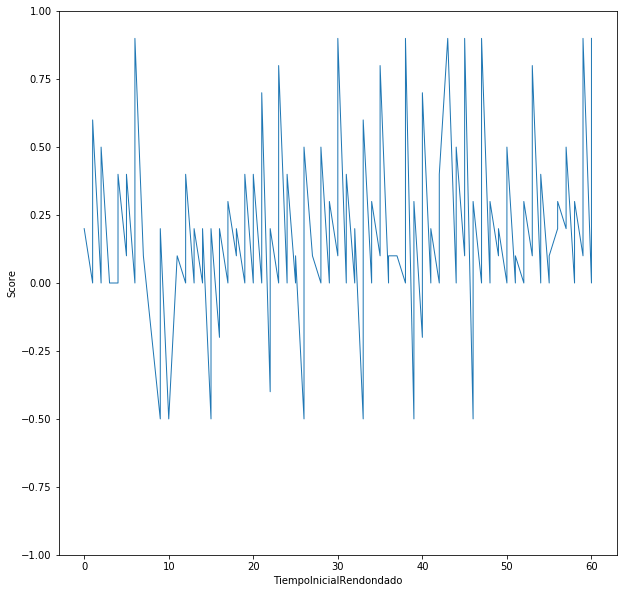

In [14]:
def speech_to_text(config, audio):
    client = speech.SpeechClient.from_service_account_json("ferrous-pact-273022-0b79c8d59d5e.json")
    response = client.long_running_recognize(config=config, audio=audio)
    
    response = response.result(timeout=10000)
    transcript = ''
    for result in response.results:
        transcript += result.alternatives[0].transcript
    
    #f= open('Transcripcion',"w+")
    #f.write(transcript)
    #f.close()
    #return transcript
    
    alternative = result.alternatives[0]

    datos = []

    

    for word_info in alternative.words:
            word = word_info.word
            start_time = word_info.start_time
            end_time = word_info.end_time

            datos.append({'frase' : word , 'TiempoInicial': start_time.total_seconds(), 'TiempoFinal':end_time.total_seconds() ,'Score': sample_analyze_sentiment(word)[0]})
            #print(
            #    f"Word: {word}, start_time: {start_time.total_seconds()}, end_time: {end_time.total_seconds()}"
            #)
            sample_analyze_sentiment(word)

    
    df = pd.DataFrame(datos)
    df.to_csv('ResultadosGoogle.csv', sep =';')

    #Visualizacion 
    
    df['TiempoInicialRendondado'] =  df['TiempoInicial'].apply(lambda x: round(x,0))
    plt.figure( figsize= (10,10))
    sns.lineplot(data = df, x = 'TiempoInicialRendondado', y = 'Score',estimator=None, lw=1,err_style="bars",markers="o")
    plt.ylim([-1, 1])
    plt.show()

    return df

datos = speech_to_text(config, audio)


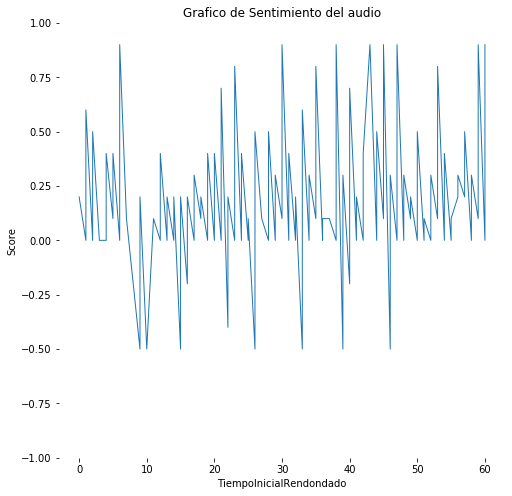

In [58]:
plt.figure( figsize= (8,8))
sns.lineplot(data = datos, x = 'TiempoInicialRendondado', y = 'Score',estimator=None, lw=1,err_style="bars",markers=True)
plt.ylim([-1, 1])
plt.title('Grafico de Sentimiento del audio')
sns.despine(left=True, bottom=True)
plt.show()

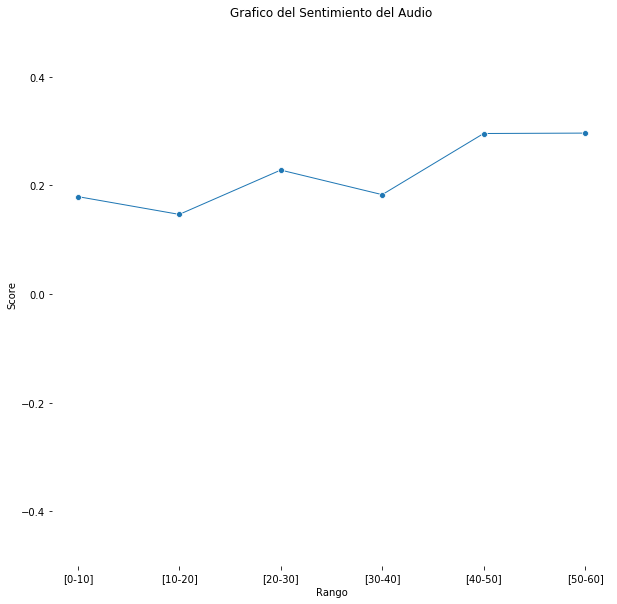

In [51]:
prueba = datos.copy()

prueba['Rango'] = ''
contar = 0

for x in prueba['TiempoInicialRendondado']:
    
    if x <= 10:
        prueba.iloc[contar,5] = '[0-10]'
    elif x > 10 and x <=20:
        prueba.iloc[contar,5] = '[10-20]'
    elif x > 20 and x <= 30:
        prueba.iloc[contar,5] = '[20-30]'
    elif x > 30 and x <= 40:
        prueba.iloc[contar,5] = '[30-40]'
    elif x > 40 and x <= 50:
        prueba.iloc[contar,5] = '[40-50]'
    else:
        prueba.iloc[contar,5] = '[50-60]'
    contar = contar + 1
    
#prueba.groupby(['Rango']).mean()['Score']
#prueba

prueba = prueba.loc[prueba['Score'] != 0]

prueba = prueba.groupby(['Rango']).mean()['Score'].reset_index()


plt.figure( figsize= (10,10))
sns.lineplot(data = prueba, x = 'Rango', y = 'Score',estimator=None, lw=1,err_style="bars",markers=True, marker="o")
plt.ylim([-0.5, 0.5])
plt.title('Grafico del Sentimiento del Audio')
sns.despine(left=True, bottom=True)
plt.show()

## Nube de palabras Audio

In [63]:
resultado_global['Texto'].values[0]

'me pongo a pensar en todo lo que hice para tener nadie que creo que es en la parte que más me llena de felicidad, que si hubiera hecho hubiera tenido nada y nada y algo más que está haciendo algo que se sabe que no le va a llevar a ningún lado, pero lo hace con toda la energía posible y lo hace como soñando que eso sí lo puedas llevar un lugar o dímelo, que voy como que siento que es la mejor manera de tomárselo y ese del consejo que le quiero dar cuando no mira donde quieres estar, pero si miras que te gusta ser lo más probable que de alguna manera termine en un lugar, que no sabes dónde es, pero que te va a gustar es como salir a andar en auto, por qué te gusta andar en auto y no esperar si hubiera ningún lugar en particular, pero sí que cuando se que se pueda disfrutarlo se entiende es como disfrutar el camino y no disfrutar solamente de la recompensa, que te va a dar el camino, por eso vuelvo a decir lo mismo porque realmente quiere que se le vea bien la cabeza, si es que puedo da

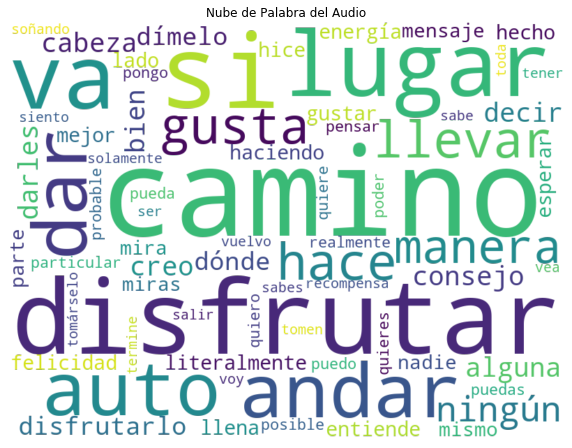

In [89]:
NUMERO_PALABRAS = 10000
lista_de_textos = resultado_global['Texto']
STOPWORDS = set(stopwords.words('spanish'))


# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words =STOPWORDS, max_features=NUMERO_PALABRAS)
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)

# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

df2 = pd.DataFrame({'words': words, 'freq':words_freq}, columns=['words', 'freq'])

#df2.sort_values('freq', ascending = False).head(10)
data = dict(zip(df2['words'].tolist(), df2['freq'].tolist()))

wc = WordCloud(width=800, height=600, mode='RGBA', background_color=None).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title('Nube de Palabra del Audio')
plt.axis('off')
plt.show()